### Beer Fermentation PINN with DO & pH

In [2]:
# Python dependencies # Standard libraries
import os      # Operating system interfaces (file paths, directories)
import time    # Time-related functions
import math    # Mathematical functions
import json    # For handling JSON data

# Data handling and plotting
import numpy as np             # Numerical computing
import pandas as pd            # Data manipulation
import matplotlib.pyplot as plt # Plotting and visualization

# PyTorch libraries for deep learning
import torch
import torch.nn as nn          # Neural network modules
import torch.nn.functional as F # Activation functions and other functional ops
from torch.autograd import grad # For computing gradients (useful in PINNs or custom losses)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [5]:
# Load dataset
file_path = "data/02 - IPA - SA-05.csv"  # Fermentation Dataset
df = pd.read_csv(file_path)

# Display info
print("First 5 rows:\n", df.head())
print("\nLast 5 rows:\n", df.tail())
print("\nColumns:\n", df.columns)
print("\nDataset shape:", df.shape)

First 5 rows:
        Timestamp (BST)  Hours from Pitch  DO (mg/L)    pH  Gravity (°P)  \
0  2022-06-17 16:00:00              0.01       1.72  5.77          12.0   
1  2022-06-17 16:10:00              0.18       1.69  5.76          12.0   
2  2022-06-17 16:20:00              0.35       1.70  5.76          12.0   
3  2022-06-17 16:30:00              0.52       1.60  5.76          12.0   
4  2022-06-17 16:40:00              0.68       1.54  5.76          12.0   

   Pressure (Bar)  Fluid Temp (°C)  Ambient Temp (°C)  Conductivity (uS/cm)  
0            0.07             22.4               20.0                2418.0  
1            0.07             22.2               20.0                2424.0  
2            0.07             22.1               20.0                2427.0  
3            0.07             22.1               19.0                2424.0  
4            0.07             22.1               19.0                2427.0  

Last 5 rows:
           Timestamp (BST)  Hours from Pitch  DO (mg

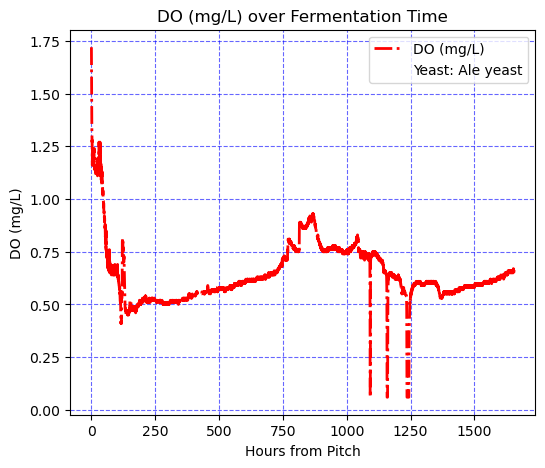

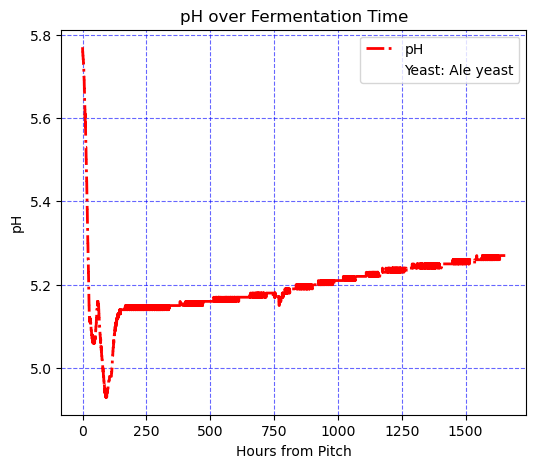

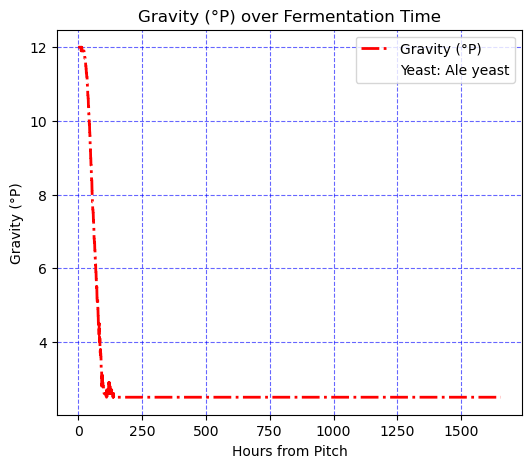

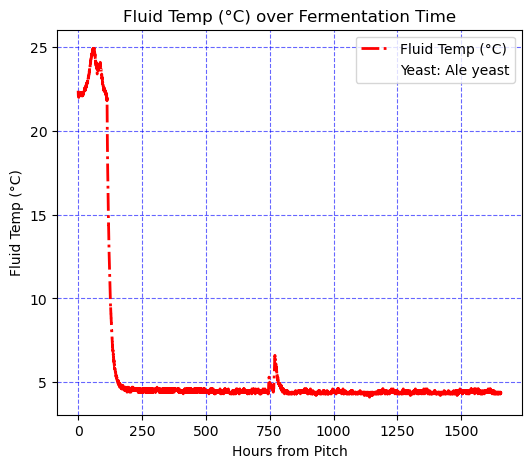

In [6]:
# Convert timestamp to datetime
df["Timestamp (BST)"] = pd.to_datetime(df["Timestamp (BST)"])

# Fermentation variables ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]
variables = ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]

# Yeast type
yeast_type = "Ale yeast"

# Plots | Figures
for var in variables:
    plt.figure(figsize=(6, 5))
    
    # Main variable line
    plt.plot(df["Hours from Pitch"], df[var], label=var, linewidth=2, color="red", linestyle="-.")
    
    # Add yeast type as a legend entry (invisible plot)
    plt.plot([], [], ' ', label=f"Yeast: {yeast_type}")
    
    plt.xlabel("Hours from Pitch")
    plt.ylabel(var)
    plt.title(f"{var} over Fermentation Time")
    plt.grid(True, linestyle="--", color="blue", alpha=0.6)
    plt.legend()
    plt.show()


In [12]:
# Hyperparameters |PINN Settings
# Neural network architecture 
layers = [4, 128, 128, 128, 5] # inputs: [t_scaled, T_scaled, DO_scaled, pH_scaled] -> outputs: X, Cs, Ce, DO_pred, pH_pred

# Collocation and training settings
N_f = 3000               # Number of collocation points for ODE residuals
lr = 5e-4                # Learning rate (Adam)
adam_epochs = 5000       # Number of Adam optimizer epochs

# Physics-informed modeling (Haldane + temperature correction)
use_full_haldane = True     # Enable full Haldane inhibition model
Y_e_s_fixed = 0.51          # Ethanol yield [g ethanol / g sugar]

# Temperature-dependent kinetic parameters (Arrhenius)
mu_ref = 0.4                # Reference μ_max [1/h]
K_s_ref = 0.1               # Substrate affinity constant [g/L]
K_i_ref = 50.0              # Substrate inhibition constant [g/L]
T_ref = 30.0                # Reference temperature [°C]
Ea = 5000.0                 # Activation energy [J/mol]
R = 8.314                   # Universal gas constant [J/mol/K]

# Loss function weights
w_data_cs = 10.0    # Measured substrate (from Gravity → Cs)
w_data_do = 10.0    # Measured DO
w_data_ph = 5.0     # Measured pH
w_data_ce = 5.0     # Ethanol estimation
w_phys = 100.0      # Physics (ODE residuals)
w_ic = 100.0        # Initial conditions

# Numerical stability
eps = 1e-8

In [13]:
# Information about the beer fermentation dataset
df_info = {
    "shape": df.shape,  # Number of rows and columns
    "columns": list(df.columns),  # List of column names
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),  # Data types for each column
    "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows
    "nan_counts": df.isna().sum().to_dict()  # Count missing values in each column
}

# Print the information in JSON format for readability
print(json.dumps(df_info, indent=2))

{
  "shape": [
    9933,
    9
  ],
  "columns": [
    "Timestamp (BST)",
    "Hours from Pitch",
    "DO (mg/L)",
    "pH",
    "Gravity (\u00b0P)",
    "Pressure (Bar)",
    "Fluid Temp (\u00b0C)",
    "Ambient Temp (\u00b0C)",
    "Conductivity (uS/cm)"
  ],
  "dtypes": {
    "Timestamp (BST)": "datetime64[ns]",
    "Hours from Pitch": "float64",
    "DO (mg/L)": "float64",
    "pH": "float64",
    "Gravity (\u00b0P)": "float64",
    "Pressure (Bar)": "float64",
    "Fluid Temp (\u00b0C)": "float64",
    "Ambient Temp (\u00b0C)": "float64",
    "Conductivity (uS/cm)": "float64"
  },
  "head": {
    "Timestamp (BST)": [
      "2022-06-17 16:00:00",
      "2022-06-17 16:10:00",
      "2022-06-17 16:20:00",
      "2022-06-17 16:30:00",
      "2022-06-17 16:40:00",
      "2022-06-17 16:50:00",
      "2022-06-17 17:00:00",
      "2022-06-17 17:10:00"
    ],
    "Hours from Pitch": [
      0.01,
      0.18,
      0.35,
      0.52,
      0.68,
      0.85,
      1.02,
      1.18
    ],
    

/var/folders/7q/1pqndbz17fbd8s_b61735x400000gn/T/ipykernel_40930/1581093731.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows


In [ ]:
# Columns in the CSV:
# 'Timestamp (BST)', 'Hours from Pitch', 'DO (mg/L)', 'pH', 
# 'Gravity (°P)', 'Pressure (Bar)', 'Fluid Temp (°C)', 'Ambient Temp (°C)', 'Conductivity (uS/cm)'

# - 'Hours from Pitch' as time (t)
# - 'Gravity (°P)' as Plato (to compute substrate concentration)
# - 'Fluid Temp (°C)' as temperature input

t_data = df['Hours from Pitch'].to_numpy(dtype=float)
plato = df['Gravity (°P)'].to_numpy(dtype=float)
temp = df['Fluid Temp (°C)'].to_numpy(dtype=float)
DO_meas = df['DO (mg/L)'].to_numpy(dtype=float)
pH_meas = df['pH'].to_numpy(dtype=float)

In [15]:
# Plato to Sugar Concentration Conversion (g/L) 
def plato_to_concentration(P):
    """
    Convert Plato (°P) to sugar concentration (g/L) using an empirical density polynomial.
    Parameters:
        P (float or np.array): Plato value(s)
    Returns:
        Cs (float or np.array): Sugar concentration in g/L
    """
    # Density of wort in g/mL (empirical polynomial fit)
    rho = 1 + 0.003867 * P + 0.00001243 * P**2 + 0.000000013 * P**3
    
    # Convert to sugar concentration (g/L)
    Cs = (P / 100.0) * rho * 1000.0
    return Cs

# Apply conversion to your dataset
Cs_data = plato_to_concentration(plato)

# First 5 sugar concentrations
print("First 5 sugar concentrations (g/L):", Cs_data[:5])


First 5 sugar concentrations (g/L): [125.78596608 125.78596608 125.78596608 125.78596608 125.78596608]


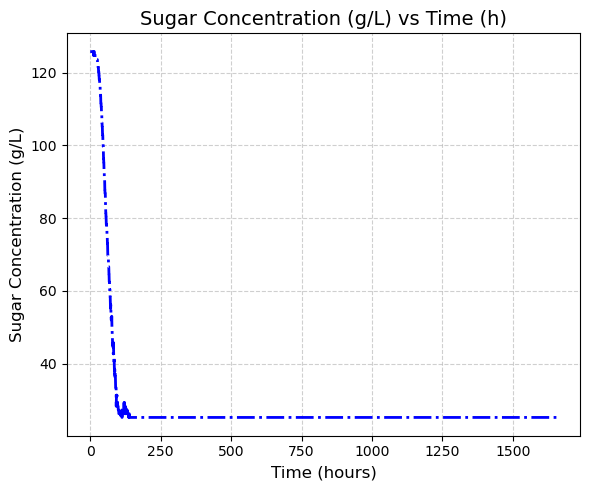

In [17]:
# Plot Sugar Concentration Over Time 
plt.figure(figsize=(6, 5))
plt.plot(t_data, Cs_data, linewidth=2, color="blue", linestyle="-.")

plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Sugar Concentration (g/L)", fontsize=12)
plt.title("Sugar Concentration (g/L) vs Time (h)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Plato → ethanol concentration (g/L)

In [18]:
def plato_to_abv(P, P0):
    """
    Estimate ABV (%) from Plato drop.
    Parameters:
        P  (float or np.array): Current Plato
        P0 (float): Initial Plato
    Returns:
        ABV (float or np.array): Alcohol by volume in %
    """
    ABV = (P0 - P) * 0.131
    ABV[ABV < 0] = 0
    return ABV


In [19]:
def abv_to_ethanol(ABV):
    """
    Convert ABV (%) to ethanol concentration (g/L).
    """
    Ce = ABV * 7.89
    return Ce


In [20]:
def plato_to_ethanol(P, P0):
    """
    Convert current Plato to ethanol concentration (g/L)
    based on initial Plato and empirical ABV conversion.
    """
    ABV = plato_to_abv(P, P0)
    Ce = abv_to_ethanol(ABV)
    return Ce


In [21]:
P0 = plato[0]  # initial Plato (original gravity)
Ce_data = plato_to_ethanol(plato, P0)

print("First 5 ethanol concentrations (g/L):", Ce_data[:5])


First 5 ethanol concentrations (g/L): [0. 0. 0. 0. 0.]


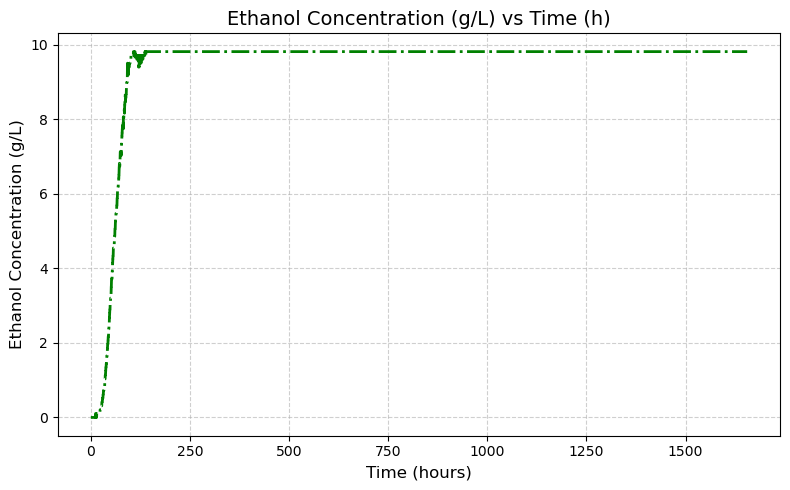

In [23]:
# Plot Ethanol Concentration
plt.figure(figsize=(8, 5))
plt.plot(t_data, Ce_data, linewidth=2, color="green", linestyle="-.")
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Ethanol Concentration (g/L)", fontsize=12)
plt.title("Ethanol Concentration (g/L) vs Time (h)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
# t_min = The starting time of fermentation 
# t_max = The final time of fermentation
t_min, t_max = float(np.min(t_data)), float(np.max(t_data))

print(f"Physical Time Range: {t_min:.2f} h to {t_max:.2f} h")
print(f"Total Fermentation Time: {t_max - t_min:.2f} h")

Physical Time Range: 0.01 h to 1655.47 h
Total Fermentation Time: 1655.46 h
